# Emulation of the TIP package using GPs

### J Gómez-Dans (NCEO/UCL)

This notebook demonstrates the emulation of bihemispherical reflectance using the two stream RT package from Pinty *et al.*. We make use of the [`gp_emulator` package](http://github.com/jgomezdans/gp_emulator) for this. We will produce an emulator for the visible and nir bands, and test emulator performance, as well as emulated gradient performance with respect to the original model. 

We make use of the Python bindings to the Two Stream model (see relevant README file).

In [1]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
%matplotlib inline

import gp_emulator
from TwoSInterface import twostream_solver




Bad key "axes.spines.right" on line 223 in
/data/netapp_3/ucfajlg/python/twostream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.spines.top" on line 224 in
/data/netapp_3/ucfajlg/python/twostream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution


## A wrapper to 2stream

We start by producing a wrapper to the RT code. This is because at the moment, we just want to expose BHR, not absorbed fluxes and whatever.

In [2]:
def two_stream_model ( x, sun_angle ):
    """This function calculates absorption in the visible and NIR
    for a given parameter vector x.

    The parameter vector is:
    1. $\omega_{leaf,VIS}$
    2. $d_{leaf, VIS}$
    3. $r_{soil, VIS}$
    4. $\omega_{leaf,NIR}$
    5. $d_{leaf, NIR}$
    6. $r_{soil, NIR}$
    7. $LAI$
    
    """
    from TwoSInterface import twostream_solver
    #if np.any ( x[:-1] > 1.) or np.any ( x <= 0.01) \
    #         or ( x[-1] > 10):
    #    return  [ -1, -1]
    # These structural effective parameters are hardwired to be 1
    structure_factor_zeta = 1.
    structure_factor_zetastar = 1.
    # Calculate leaf properties in VIS and NIR
    # This first version of calculating refl & trans uses a slightly different
    # formulation to Bernard's. This ought to help with the priors
    # For the time being it's switched off
    ####################### NEW VERSION ###########################################
    #tvis = x[0]*x[1]
    #rvis = x[0] - tvis
    
    #tnir = x[3]*x[4]
    #rnir = x[3] - tnir
    # Or, according to the paper...
    ####################### Pinty et al, 2008 VERSION ###########################################
    # Transmittance is single scattering albedo divided by (1+asymmetry)
    tvis = x[0]/(1.+x[1])
    rvis = x[1]*x[0]/(1+x[1])

    tnir = x[3]/(1.+x[4])
    rnir = x[4]*x[3]/(1+x[4])


    # Model visible
    collim_alb_tot_vis, collim_tran_tot_vis, collim_abs_tot_vis, \
        iso_alb_tot_vis, iso_tran_tot_vis, iso_abs_tot_vis = \
        twostream_solver( rvis, tvis, x[2], x[6], \
        structure_factor_zeta, structure_factor_zetastar, \
        sun_angle )
    # Model NIR
    collim_alb_tot_nir, collim_tran_tot_nir, collim_abs_tot_nir, \
        iso_alb_tot_nir, iso_tran_tot_nir, iso_abs_tot_nir = \
        twostream_solver( rnir, tnir, x[5], x[6], \
        structure_factor_zeta, structure_factor_zetastar, \
        sun_angle )
    # For fapar we return 
    #[ iso_abs_tot_vis, iso_abs_tot_nir]
    return  [ collim_alb_tot_vis, collim_alb_tot_nir ]

So `two_stream_mode` takes a vector of parameters, and a sun angle (this is actually not used here as we're calculating BHR, but you might want to change the outputs from this, so it's there in case you need it, to make it obvious), and it returns visible and NIR albedos. 

Let's see how we can emulate this. We just need to set the parameter boundaries, and provide a function that returns each band in turn...

In [3]:
from functools import partial

# This sets up the model parameters, as well as their min/max boundaries
parameters = ["omega_VIS", "d_VIS", "omega_NIR", "d_NIR", "a_VIS", "a_NIR", "LAI"]
min_vals = np.ones(7)*.001
max_vals = np.ones(7)*0.95
max_vals[-1] = 10. # LAI!

# The number of training samples and validation samples. For training, you can probably get away with 100, but 150
# is safer
# validation is as many as you can stomach!
n_train = 350
n_validate = 1000

# A wrapper of the 2stream model wrapper to select the band

def the_simulator ( x, band ):
    p, sun_angle = x
    if band.upper() == "VIS":
        return two_stream_model ( p, sun_angle )[0]
    elif band.upper() == "NIR":
        return two_stream_model ( p, sun_angle )[1]
    

emulation_test = []

for band in ["VIS", "NIR"]:
    simulator = partial ( the_simulator, band=band )
    xx = gp_emulator.create_emulator_validation (
                simulator, parameters, min_vals, max_vals, n_train, n_validate, do_gradient=True, 
                n_tries=15, args=(30,) )
    emulation_test.append ( xx )


After 15, the minimum cost was -1.277498e+03
[9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 0.00099989999999999996]
None
After 15, the minimum cost was -1.331487e+03
[9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 9.4899999999999989e-05, 0.00099989999999999996]
None


/home/ucfajlg/.local/lib/python2.7/site-packages/gp_emulator/GaussianProcess.py:176: RuntimeWarning: Optimisation resulted in linear algebra error. Returning last loglikelihood calculated, but this is fishy
  RuntimeWarning )


In the above formulation, I have been a bit lazy: there's no point in worrying about the VIS parameters if you're only worried about the NIR output, and viceversa. The emulators thus would have 4 input parameters (with only $LAI_{eff}$ being common to both). This would result in simpler emulators, and is maybe the way to go, but it appears that even with this said, the emulators work reasonably well. Let's see how well they work comparing the outputs with the validation dataset and providing some statistics on the agreement.

  Band  Slope    Intercept      R    StdErr    MAE
   VIS &  0.999 &  0.000 &  1.000 & 5.922e-04 & 3.808e-02\\
   NIR &  0.993 &  0.001 &  1.000 & 7.513e-04 & 6.351e-02\\


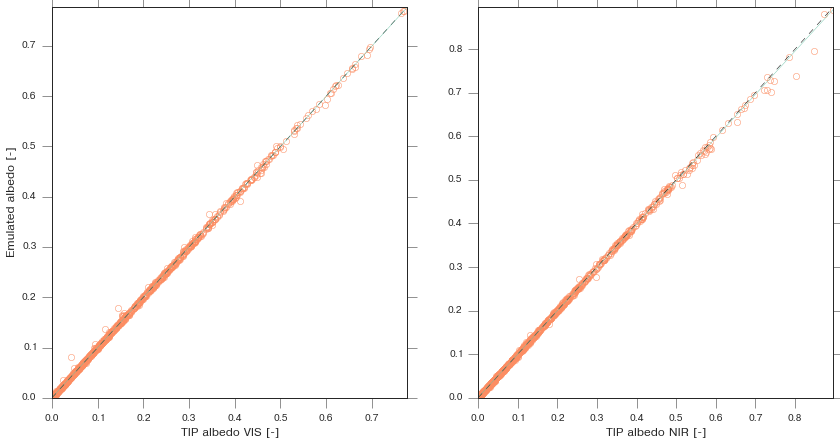

In [4]:
fig, axs = plt.subplots ( nrows=1, ncols=2, figsize=(14,7))
axs = axs.flatten()

print "%6s %6s %12s %6s %6s %6s" % ( "Band", "Slope", "Intercept", "R", "   StdErr", "MAE")
for iband, band_name in enumerate(["VIS", "NIR"]):
    gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[iband]

    slope, intercept, r_value, p_value, std_err = linregress( validate_output, emulated_validation.squeeze() )
    axs[iband].plot ( validate_output, emulated_validation, 'o', mec="#FC8D62", mfc="none", rasterized=True )
    ymax = np.max ( validate_output.max(), emulated_validation.max() )
    axs[iband].plot ( [0, 1.2*ymax], [0, 1.2*ymax], 'k--', lw=0.5)
    p = np.polyfit ( validate_output, emulated_validation, 1)
    mae = np.abs(validate_output- emulated_validation.squeeze()).max()
    print "%6s & %6.3f & %6.3f & %6.3f & %6.3e & %6.3e\\\\" % (band_name, slope, intercept, r_value, std_err, mae),
    x = np.linspace(0, 1.2*ymax, 5)
    axs[iband].plot ( x, np.polyval ( p, x), '-', lw=0.4  )
    axs[iband].set_ylim ( 0, ymax )
    axs[iband].set_xlim ( 0, ymax )
    
    #axs[iband].set_title ( "MODIS Band %d" % (iband+1))
    print
axs[0].set_ylabel ( "Emulated albedo [-]")
axs[0].set_xlabel ( "TIP albedo VIS [-]")
axs[1].set_xlabel ( "TIP albedo NIR [-]")

Now for the gradient (note that we do first the NIR and then the VIS, and that I'm ignoring the 0-gradient parameters here):

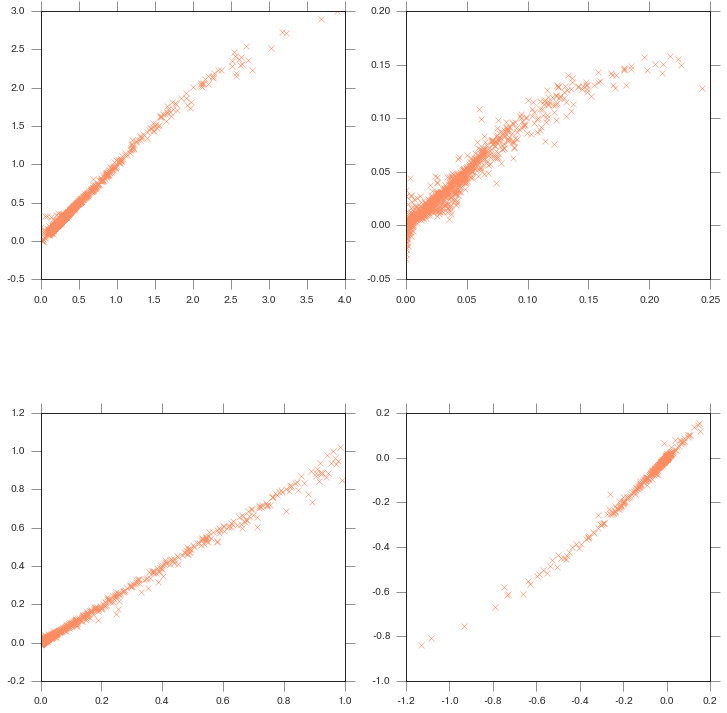

In [5]:
plt.figure(figsize=(12,12))
gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[1]
for i,p in enumerate( [ 3,4,5,6] ):
    plt.subplot( 2,2,i+1)
    plt.plot ( validate_gradient[:,p], emulated_gradient[:,p], 'x')

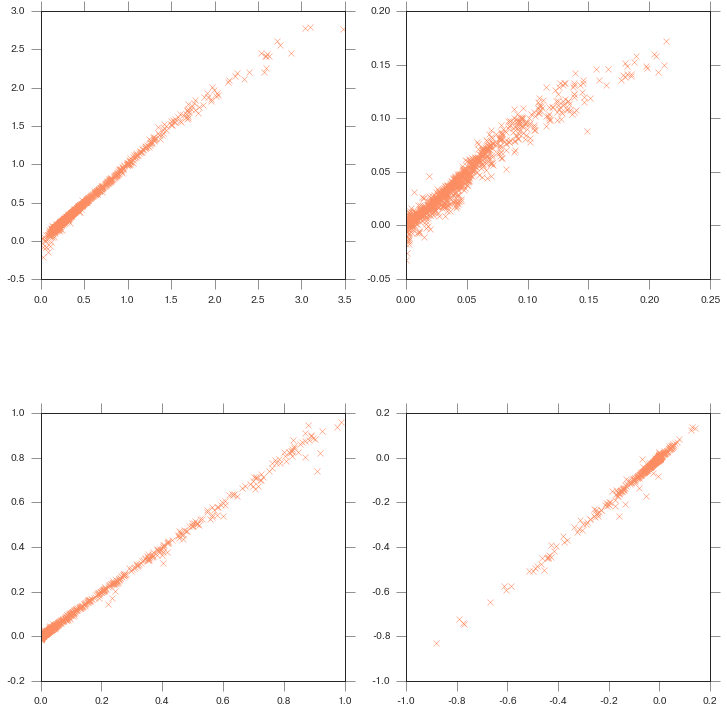

In [6]:
plt.figure(figsize=(12,12))
gp, validate, validate_output, validate_gradient, emulated_validation, emulated_gradient = emulation_test[0]
for i,p in enumerate( [ 0,1,2,6] ):
    plt.subplot( 2,2,i+1)
    plt.plot ( validate_gradient[:,p], emulated_gradient[:,p], 'x')

Some comments are in order now. It would appear that to get a good approximation to the gradient of the TIP, we do need to have a pretty large number of training sets are required. Note that we're only comparing with finite differences gradient, a comparison with the adjoint would obviously be advantageous here. 

However, if we were to compare the gradient of $J_{obs}(\vec{x})$ calculated with the emulators and with the full model, only some 150 forward runs are required. This is something to maybe think about if the goal of the emulation is a cost function minimisation or a local linearisation of the RT model: in the first case, we can probably compromise in the quality of the gradient (as it will be "projected" by the observational uncertainty and so on), and in the second case, we probably want to have an accurate gradient. More robust tests with the TIP adjoint might be needed.

The need to have 4-input emulators rather than 7-input emulators is probably a good step, but one I haven't done yet...